In [1]:
# Imports
import numpy as np
import pandas as pd
import imutils
import cv2
import sklearn
import seaborn as sns
 
#%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score, classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict, cross_validate
from sklearn.decomposition import PCA
from sklearn import tree
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_selection import VarianceThreshold
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.manifold import TSNE

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.utils import np_utils
from keras import backend as K

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from quickdraw import QuickDrawDataGroup
from quickdraw import QuickDrawData

from PIL import Image, ImageTk
from urllib import request



# Loading Dataset
- API documentation: https://quickdraw.readthedocs.io/en/latest/


In [2]:
%%time
print("--------------------------------")
print("LOADING THE DATA")
print("--------------------------------")

target = []
target_names = ["microwave", "flower", "apple", "broom", "eyeglasses"]
nombre = 50
data_array_array = []



for i in target_names:
    dataset = QuickDrawDataGroup(i, max_drawings=nombre)
    name = target_names.index(i)+1
    maxi=0
    
    for d in dataset.drawings:
        maxi = maxi +1
        
        data_array = np.zeros((255*255))
        data = np.asarray(d.image)
        #plt.imshow(d.image)
        if d.recognized == True:
            target.append(name)
            for i in range(255):
                for j in range(255):
                    if(data[i][j][0]==0 and data[i][j][1]==0 and data[i][j][2]==0):
                        data_array[i*255 + j] = 1
    
            data_array_array.append(data_array)
            
        if(maxi==nombre):
            break

    print(name)
    
print("--LOADING COMPLETED--")

print("--PERFORMING TSNE and PCA--")
  

train = np.array(data_array_array)
train = sklearn.preprocessing.StandardScaler().fit_transform(train)
tsne = TSNE(n_components = 2, random_state=0)
     
pca = sklearn.decomposition.PCA(n_components=10)
pca_res_50 = pca.fit_transform(train)
tsne_res = tsne.fit_transform(pca_res_50)

converted_data = tsne_res
    
print("--TSNE and PCA COMPLETED--")

# training data 70%, test data 30%
(trainData, testData, trainLabels, testLabels) = train_test_split(converted_data, target, test_size=0.3, random_state=42)
    
# validation data: 10% of training data 
(trainData, valData, trainLabels, valLabels) = train_test_split(trainData, trainLabels, test_size=0.1, random_state=42)


--------------------------------
LOADING THE DATA
--------------------------------
loading microwave drawings
load complete
1
loading flower drawings
load complete
2
loading apple drawings
load complete
3
loading broom drawings
load complete
4
loading eyeglasses drawings
load complete
5
--LOADING COMPLETED--
--PERFORMING TSNE and PCA--
--TSNE and PCA COMPLETED--
Wall time: 52.5 s


Test: Feature Selection
- code based on the tutorial of the lectures: https://github.com/alerenda/878II-Python/blob/main/4_ScikitLearn_Tutorial_Complete.ipynb

In [ ]:
print("--------------------------------")
print("TEST: FEATURE SELECTION")
print("--------------------------------")
print("Data with using pca and t-sne")
print()

feat_selector = VarianceThreshold(threshold=0.2)
trainData_new = feat_selector.fit_transform(trainData)

print(np.asarray(trainData_new).shape)
print(np.asarray(trainData).shape)
print(trainData_new[1])
print(trainData[1])

print("--------------------------------")
print("Data without using pca and t-sne")
print("Output: 'No feature in X meets the variance threshold 0.20000'")

'''feat_selector = VarianceThreshold(threshold=0.9)
trainData_new = feat_selector.fit_transform(data_array_array)

print(np.asarray(trainData_new).shape)
print(np.asarray(data_array_array).shape)
print(trainData_new[1])
print(data_array_array[1])'''

Creating table for model evaluation

In [3]:
# create an overview

overview = []
overview_names = ["Model", "Accuracy", "Precision", "Recall", "F1-Score"]

# Building Classification Models
Classifier selection based on: https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html

Classifiers with using holdout-method and 4 times cross-validation method for validation 
- k-nearest Neighbor
    - holdout-method
    - cross-validation method
- Support Vector Machine
- Random Forest
    - holdout-method
    - cross-validation method
- Decision Tree
    - holdout-method
    - cross-validation method
- Multi-layer Perceptron
- Gaussian Naive Bayes
- Gaussian Process Classification based on LaPlace approximation

### k-nearest Neighbor
- source code based on:  https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html


In [4]:
%%time
print("--------------------------------")
print("Method: k-nearest Neighbor")
print("--------------------------------")
print('FIRST MODEL with holdout-method')
print()
# model with train data, validation data and test data

kVals = range(1, 30, 2) 
accuracies = []

# find best k
for k in kVals:
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(trainData, trainLabels)

    score = model.score(valData, valLabels)
    #print("k=%d, accuracy=%.2f%%" % (k, score * 100))
    accuracies.append(score)

i = int(np.argmax(accuracies))
print("k=%d achieved highest accuracy of %.2f%% on validation data" % (kVals[i], accuracies[i] * 100))
print()


# build and train classifier 
model = KNeighborsClassifier(n_neighbors=kVals[i])
model.fit(trainData, trainLabels)

predictions = model.predict(testData)
print("Accuracy of model: %.2f%%" % (accuracy_score(testLabels, predictions) * 100))
print()

# classification report
print("EVALUATION")
print(classification_report(testLabels, predictions, target_names=target_names))



'''print("Confusion Matrix")
testL = np.array(testLabels)
cm = confusion_matrix(testL, predictions)

cmdf = pd.DataFrame(cm, index=range(5), columns=range(5))

ax = sns.heatmap(cmdf, annot=True, cmap="Blues", fmt="g")
ax.set(ylabel="Actual", xlabel="Predicted")
ax.xaxis.set_ticklabels(target_names)
ax.yaxis.set_ticklabels(target_names)'''



--------------------------------
Method: k-nearest Neighbor
--------------------------------
FIRST MODEL with holdout-method

k=1 achieved highest accuracy of 88.24% on validation data

Accuracy of model: 91.67%

EVALUATION
              precision    recall  f1-score   support

   microwave       1.00      0.85      0.92        13
      flower       0.74      0.93      0.82        15
       apple       1.00      0.93      0.97        15
       broom       1.00      0.86      0.92        14
  eyeglasses       0.94      1.00      0.97        15

    accuracy                           0.92        72
   macro avg       0.93      0.91      0.92        72
weighted avg       0.93      0.92      0.92        72

Wall time: 84.6 ms


'print("Confusion Matrix")\ntestL = np.array(testLabels)\ncm = confusion_matrix(testL, predictions)\n\ncmdf = pd.DataFrame(cm, index=range(5), columns=range(5))\n\nax = sns.heatmap(cmdf, annot=True, cmap="Blues", fmt="g")\nax.set(ylabel="Actual", xlabel="Predicted")\nax.xaxis.set_ticklabels(target_names)\nax.yaxis.set_ticklabels(target_names)'

In [5]:
%%time
print("--------------------------------")
print('SECOND MODEL - with cross-validation')
print()
# model with integrated split of train and test data

accuracies = []

# 10-cross fold
cv = 10

# find best k
for k in kVals:
    model = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(model, converted_data, target, cv=cv, n_jobs=-1, scoring='accuracy')
    accuracies.append(scores.mean())

i = int(np.argmax(accuracies))
print("k=%d achieved highest accuracy of %.2f%%" % (kVals[i], accuracies[i] * 100))
print()


# build and train classifier 
model = KNeighborsClassifier(n_neighbors=kVals[i])
predictions = cross_val_predict(model, converted_data, target, cv=cv, n_jobs=-1)

print("Accuracy of model: %.2f%%" % (accuracy_score(target, predictions) * 100))
print()

# classification report
print("EVALUATION")
print(classification_report(target, predictions, target_names=target_names))


--------------------------------
SECOND MODEL - with cross-validation

k=3 achieved highest accuracy of 92.81%

Accuracy of model: 92.83%

EVALUATION
              precision    recall  f1-score   support

   microwave       0.90      0.94      0.92        50
      flower       0.86      0.90      0.88        48
       apple       0.98      0.96      0.97        47
       broom       0.96      0.91      0.93        47
  eyeglasses       0.95      0.93      0.94        45

    accuracy                           0.93       237
   macro avg       0.93      0.93      0.93       237
weighted avg       0.93      0.93      0.93       237

Wall time: 4.3 s


In [6]:
# add to overview
# cross-validation reaches better accuracy than holdout-method 
dic = classification_report(target, predictions, target_names=target_names, output_dict=True)

prec = []
rec = []
fsc = []

for t in target_names:
    prec.append(dic[t]['precision']) 
    rec.append(dic[t]['recall'])
    fsc.append(dic[t]['f1-score'])

overview.append(["knn", dic['accuracy'], np.mean(prec), np.mean(rec), np.mean(fsc)])

### Support Vector Machine
- source code based on logic:  https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html


In [7]:
%%time
print("--------------------------------")
print("Method: Support Vector Machine")
print("--------------------------------")
print('FIRST MODEL with holdout-method')
print()
# model with train data, validation data and test data


# find best Classifier
accuracies = []
classifier = []
classifier_names = []

classifier.append(LinearSVC())
classifier_names.append("SVM with linear support vector")
classifier.append(SVC(kernel='linear', ))
classifier_names.append("SVM with linear-kernel")
classifier.append(SVC(kernel='sigmoid'))
classifier_names.append("SVM with sigmoid-kernel")
classifier.append(SVC(kernel='rbf'))
classifier_names.append("SVM with rbf-kernel")

for m in classifier:
    model = m
    model.fit(trainData, trainLabels)

    predictions = model.predict(testData)
    accuracies.append(accuracy_score(testLabels, predictions))
    #print("Accuracy of model: %.2f%%" % (accuracy_score(testLabels, predictions) * 100))

    
i = int(np.argmax(accuracies))

model = classifier[i]
model.fit(trainData, trainLabels)

predictions = model.predict(testData)
print(classifier_names[i])
print("Accuracy of model: %.2f%%" % (accuracy_score(testLabels, predictions) * 100))
print()

print("EVALUATION")
print(classification_report(testLabels, predictions, target_names=target_names))


--------------------------------
Method: Support Vector Machine
--------------------------------
FIRST MODEL with holdout-method

SVM with linear-kernel
Accuracy of model: 90.28%

EVALUATION
              precision    recall  f1-score   support

   microwave       0.87      1.00      0.93        13
      flower       0.78      0.93      0.85        15
       apple       0.93      0.93      0.93        15
       broom       1.00      0.79      0.88        14
  eyeglasses       1.00      0.87      0.93        15

    accuracy                           0.90        72
   macro avg       0.92      0.90      0.90        72
weighted avg       0.92      0.90      0.90        72

Wall time: 53.4 ms


C:\Users\Verena\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


In [8]:
# add to overview
dic = classification_report(testLabels, predictions, target_names=target_names, output_dict=True)

prec = []
rec = []
fsc = []

for t in target_names:
    prec.append(dic[t]['precision']) 
    rec.append(dic[t]['recall'])
    fsc.append(dic[t]['f1-score'])

overview.append([classifier_names[i], dic['accuracy'], np.mean(prec), np.mean(rec), np.mean(fsc)])

### Random forest
- source code based on logic:  https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html

In [9]:
%%time
print("--------------------------------")
print("Method: Random forest")
print("--------------------------------")

# find best number of trees
param = [10, 15, 20, 25, 30, 40, 50, 70, 90, 100, 120, 140]

accuracies = []

for p in param:
    model = RandomForestClassifier(n_estimators=p, n_jobs=-1, random_state=0)
    model.fit(trainData, trainLabels)

    score = model.score(testData, testLabels)
    #print("nr of trees=%d, accuracy=%.2f%%" % (p, score * 100))
    accuracies.append(score)

i = int(np.argmax(accuracies))

# build and train model
model = RandomForestClassifier(n_estimators=param[i], n_jobs=-1, random_state=0)
model.fit(trainData, trainLabels)

predictions = model.predict(testData)

print("Accuracy of model: %.2f%%" % (accuracy_score(testLabels, predictions) * 100))
print()


# classification report
print("EVALUATION")
print(classification_report(testLabels, predictions, target_names=target_names))



--------------------------------
Method: Random forest
--------------------------------
Accuracy of model: 90.28%

EVALUATION
              precision    recall  f1-score   support

   microwave       0.92      0.92      0.92        13
      flower       0.82      0.93      0.87        15
       apple       0.93      0.93      0.93        15
       broom       1.00      0.79      0.88        14
  eyeglasses       0.88      0.93      0.90        15

    accuracy                           0.90        72
   macro avg       0.91      0.90      0.90        72
weighted avg       0.91      0.90      0.90        72

Wall time: 1.83 s


In [10]:
%%time
print("--------------------------------")
print('SECOND MODEL - with cross-validation')
print()
# model with integrated split of train and test data

# 10-cross fold
cv = 10

# find best number of trees
param = [10, 15, 20, 25, 30, 40, 50, 70, 90, 100, 120, 140]

accuracies = []

for p in param:
    model = RandomForestClassifier(n_estimators=p, n_jobs=-1, random_state=0)
    scores = cross_val_score(model, converted_data, target, cv=cv, n_jobs=-1, scoring='accuracy')
    
    #print("nr of trees=%d, accuracy=%.2f%%" % (p, score * 100))
    accuracies.append(scores.mean())
    
i = int(np.argmax(accuracies))

# build and train model
model = RandomForestClassifier(n_estimators=param[i], n_jobs=-1, random_state=0)
predictions = cross_val_predict(model, converted_data, target, cv=cv, n_jobs=-1)

print("Accuracy of model: %.2f%%" % (accuracy_score(target, predictions) * 100))
print()

# classification report
print("EVALUATION")
print(classification_report(target, predictions, target_names=target_names))


--------------------------------
SECOND MODEL - with cross-validation

Accuracy of model: 91.14%

EVALUATION
              precision    recall  f1-score   support

   microwave       0.96      0.92      0.94        50
      flower       0.85      0.83      0.84        48
       apple       0.96      0.91      0.93        47
       broom       0.96      0.91      0.93        47
  eyeglasses       0.85      0.98      0.91        45

    accuracy                           0.91       237
   macro avg       0.91      0.91      0.91       237
weighted avg       0.91      0.91      0.91       237

Wall time: 7.27 s


In [11]:
# add to overview
# cross-validation reaches better accuracy than holdout-method 
dic = classification_report(target, predictions, target_names=target_names, output_dict=True)

prec = []
rec = []
fsc = []

for t in target_names:
    prec.append(dic[t]['precision']) 
    rec.append(dic[t]['recall'])
    fsc.append(dic[t]['f1-score'])

overview.append(["random forest", dic['accuracy'], np.mean(prec), np.mean(rec), np.mean(fsc)])

### Decision tree
- source code based on logic:  https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html

In [12]:
%%time
print("--------------------------------")
print("Method: Decision tree")
print("--------------------------------")

# find best max depth of tree
param = range(1, 10, 1)

accuracies = []

for p in param:
    model = tree.DecisionTreeClassifier(max_depth=p)
    model.fit(trainData, trainLabels)

    score = model.score(testData, testLabels)
    #print("nr of trees=%d, accuracy=%.2f%%" % (p, score * 100))
    accuracies.append(score)

i = int(np.argmax(accuracies))


# build and train model
model = tree.DecisionTreeClassifier(max_depth=param[i])
model.fit(trainData, trainLabels)



print("Number of nodes :")
print(model.tree_.node_count)
print("Number of max depth :")
print(model.tree_.max_depth)

predictions = model.predict(testData)

print("Accuracy of model: %.2f%%" % (accuracy_score(testLabels, predictions) * 100))
print()


error_rate = 1 - accuracy_score(predictions, testLabels)
print("Error rate %.2f%%" % error_rate)


# classification report
print("EVALUATION")
print(classification_report(testLabels, predictions, target_names=target_names))



--------------------------------
Method: Decision tree
--------------------------------
Number of nodes :
33
Number of max depth :
7
Accuracy of model: 88.89%

Error rate 0.11%
EVALUATION
              precision    recall  f1-score   support

   microwave       0.92      0.85      0.88        13
      flower       0.81      0.87      0.84        15
       apple       1.00      0.93      0.97        15
       broom       0.92      0.86      0.89        14
  eyeglasses       0.82      0.93      0.87        15

    accuracy                           0.89        72
   macro avg       0.90      0.89      0.89        72
weighted avg       0.89      0.89      0.89        72

Wall time: 31.2 ms


In [13]:
%%time
print("--------------------------------")
print('SECOND MODEL - with cross-validation')
print()

# model with integrated split of train and test data
# 10-cross fold
cv = 10

# find best max depth of tree
param = range(1, 10, 1)

accuracies = []

for p in param:
    model =  tree.DecisionTreeClassifier(max_depth=p)
    scores = cross_val_score(model, converted_data, target, cv=cv, n_jobs=-1, scoring='accuracy')
    
    #print("depth of trees=%d, accuracy=%.2f%%" % (p, score * 100))
    accuracies.append(scores.mean())
    
i = int(np.argmax(accuracies))

# build and train model
model = RandomForestClassifier(n_estimators=param[i], n_jobs=-1, random_state=0)
predictions = cross_val_predict(model, converted_data, target, cv=cv, n_jobs=-1)

print("Accuracy of model: %.2f%%" % (accuracy_score(target, predictions) * 100))
print()

# classification report
print("EVALUATION")
print(classification_report(target, predictions, target_names=target_names))


--------------------------------
SECOND MODEL - with cross-validation

Accuracy of model: 89.03%

EVALUATION
              precision    recall  f1-score   support

   microwave       0.90      0.88      0.89        50
      flower       0.83      0.83      0.83        48
       apple       0.93      0.89      0.91        47
       broom       0.95      0.89      0.92        47
  eyeglasses       0.84      0.96      0.90        45

    accuracy                           0.89       237
   macro avg       0.89      0.89      0.89       237
weighted avg       0.89      0.89      0.89       237

Wall time: 385 ms


In [14]:
# add to overview
dic = classification_report(target, predictions, target_names=target_names, output_dict=True)

prec = []
rec = []
fsc = []

for t in target_names:
    prec.append(dic[t]['precision']) 
    rec.append(dic[t]['recall'])
    fsc.append(dic[t]['f1-score'])

overview.append(["decision tree", dic['accuracy'], np.mean(prec), np.mean(rec), np.mean(fsc)])

### Multi layer perceptron
- source code based on logic:  https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html

In [15]:
%%time
print("--------------------------------")
print("Method: Multi layer perceptron")
print("--------------------------------")

# find best hidden layer size
param = [(50,), (100,), (784,), (50,50), (100,100), (784,784)]

accuracies = []

for p in param:
    model = MLPClassifier(hidden_layer_sizes=p, random_state=0)
    model.fit(trainData, trainLabels)

    score = model.score(testData, testLabels)
    #print( (p, score * 100))
    accuracies.append(score)

i = int(np.argmax(accuracies))

# build and fit model
model = MLPClassifier(hidden_layer_sizes=param[i], random_state=0)
model.fit(trainData, trainLabels)

predictions = model.predict(testData)

print("Accuracy of model: %.2f%%" % (accuracy_score(testLabels, predictions) * 100))
print()

# classification report
print("EVALUATION")
print(classification_report(testLabels, predictions, target_names=target_names))


--------------------------------
Method: Multi layer perceptron
--------------------------------


C:\Users\Verena\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Verena\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Verena\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Verena\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Verena\anaconda3\lib\site-packages\sklearn\neural_network\_

Accuracy of model: 93.06%

EVALUATION
              precision    recall  f1-score   support

   microwave       1.00      1.00      1.00        13
      flower       0.75      1.00      0.86        15
       apple       1.00      0.93      0.97        15
       broom       1.00      0.71      0.83        14
  eyeglasses       1.00      1.00      1.00        15

    accuracy                           0.93        72
   macro avg       0.95      0.93      0.93        72
weighted avg       0.95      0.93      0.93        72

Wall time: 13.4 s


C:\Users\Verena\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [16]:
# add to overview
dic = classification_report(testLabels, predictions, target_names=target_names, output_dict=True)

prec = []
rec = []
fsc = []

for t in target_names:
    prec.append(dic[t]['precision']) 
    rec.append(dic[t]['recall'])
    fsc.append(dic[t]['f1-score'])

overview.append(["multi layer percepton", dic['accuracy'], np.mean(prec), np.mean(rec), np.mean(fsc)])

### Naive Bayes
- source code based on logic:  https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html

In [17]:
%%time
print("--------------------------------")
print("Method: Gaussian Naive Bayes")
print("--------------------------------")

# build and fit model
model = GaussianNB()
model.fit(trainData, trainLabels)

predicted= model.predict(testData) 

print("Accuracy of model: %.2f%%" % (accuracy_score(testLabels, predictions) * 100))
print()


# classification report
print("EVALUATION")
print(classification_report(testLabels, predictions, target_names=target_names))


--------------------------------
Method: Gaussian Naive Bayes
--------------------------------
Accuracy of model: 93.06%

EVALUATION
              precision    recall  f1-score   support

   microwave       1.00      1.00      1.00        13
      flower       0.75      1.00      0.86        15
       apple       1.00      0.93      0.97        15
       broom       1.00      0.71      0.83        14
  eyeglasses       1.00      1.00      1.00        15

    accuracy                           0.93        72
   macro avg       0.95      0.93      0.93        72
weighted avg       0.95      0.93      0.93        72

Wall time: 15.6 ms


In [18]:
# add to overview
# holdout-method reachs better accuracy than cross-validation
dic = classification_report(testLabels, predictions, target_names=target_names, output_dict=True)

prec = []
rec = []
fsc = []

for t in target_names:
    prec.append(dic[t]['precision']) 
    rec.append(dic[t]['recall'])
    fsc.append(dic[t]['f1-score'])

overview.append(["gaussian naive bayes", dic['accuracy'], np.mean(prec), np.mean(rec), np.mean(fsc)])

### Gaussian process classifier
- source code based on logic:  https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html

In [19]:
%%time
print("--------------------------------")
print("Method: Gaussian Process")
print("--------------------------------")

# build and fit model
model = GaussianProcessClassifier()
model.fit(trainData, trainLabels)

predicted= model.predict(testData) 

print("Accuracy of model: %.2f%%" % (accuracy_score(testLabels, predictions) * 100))
print()


# classification report
print("EVALUATION")
print(classification_report(testLabels, predictions, target_names=target_names))



--------------------------------
Method: Gaussian Process
--------------------------------
Accuracy of model: 93.06%

EVALUATION
              precision    recall  f1-score   support

   microwave       1.00      1.00      1.00        13
      flower       0.75      1.00      0.86        15
       apple       1.00      0.93      0.97        15
       broom       1.00      0.71      0.83        14
  eyeglasses       1.00      1.00      1.00        15

    accuracy                           0.93        72
   macro avg       0.95      0.93      0.93        72
weighted avg       0.95      0.93      0.93        72

Wall time: 84.6 ms


In [20]:
# add to overview
# holdout-method reachs better accuracy than cross-validation
dic = classification_report(testLabels, predictions, target_names=target_names, output_dict=True)

prec = []
rec = []
fsc = []

for t in target_names:
    prec.append(dic[t]['precision']) 
    rec.append(dic[t]['recall'])
    fsc.append(dic[t]['f1-score'])

overview.append(["gaussian process", dic['accuracy'], np.mean(prec), np.mean(rec), np.mean(fsc)])

# Model Evaluation

['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score']
[['knn', 0.9282700421940928, 0.9304416067024764, 0.9283014184397164, 0.9290928833515537], ['SVM with linear-kernel', 0.9027777777777778, 0.9155555555555555, 0.9038095238095238, 0.9037922077922078], ['random forest', 0.9113924050632911, 0.9133324240771049, 0.9121796690307328, 0.9115324971197284], ['decision tree', 0.890295358649789, 0.8924617119575103, 0.891224586288416, 0.8908351913786696], ['multi layer percepton', 0.9305555555555556, 0.95, 0.9295238095238096, 0.9311986863711003], ['gaussian naive bayes', 0.9305555555555556, 0.95, 0.9295238095238096, 0.9311986863711003], ['gaussian process', 0.9305555555555556, 0.95, 0.9295238095238096, 0.9311986863711003]]


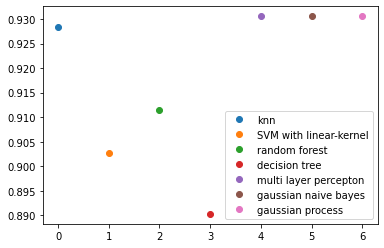

In [21]:
# show overview of all important evaluaiton metrics
print(overview_names)
print(overview)

# accuracies per classifier
for i in range(len(overview)):
    label = overview[i][0]
    val=overview[i][1]
    plt.plot(i,val,'o',label=label)
    
plt.legend()
plt.show()

# Extra

CNN works only without using PCA and Tsne as dimensionaly reduction methods (need raw data). 

Following steps:
- new dataload without data reduction
- CNN model

In [217]:
# for CNN you need image data in raw format

target = []
target_names = ["microwave", "flower", "apple", "eyeglasses", "broom"]
nombre = 50
data_array_array = []

print("--LOADING THE DATA--")

for i in target_names:
    dataset = QuickDrawDataGroup(i, max_drawings=nombre)
    name = target_names.index(i)+1
    maxi=0
    
    for d in dataset.drawings:
        maxi = maxi +1
        
        data_array = np.zeros((255*255))
        data = np.asarray(d.image)
        #plt.imshow(d.image)
        if d.recognized == True:
            target.append(name)
            for i in range(255):
                for j in range(255):
                    if(data[i][j][0]==0 and data[i][j][1]==0 and data[i][j][2]==0):
                        data_array[i*255 + j] = 1
    
            data_array_array.append(data_array)
            
        if(maxi==nombre):
            break

    print(name)
    
print("--LOADING COMPLETED--")


# training data 70%, test data 30%
(trainData, testData, trainLabels, testLabels) = train_test_split(data_array_array,
	target, test_size=0.3, random_state=42)


# validation data: 10% of training data 
(trainData, valData, trainLabels, valLabels) = train_test_split(trainData, trainLabels,
	test_size=0.1, random_state=42)



# size of each data split
print("training data points: {}".format(len(trainLabels)))
print("validation data points: {}".format(len(valLabels)))
print("testing data points: {}".format(len(testLabels)))



--LOADING THE DATA--
loading microwave drawings
load complete
1
loading flower drawings
load complete
2
loading apple drawings
load complete
3
loading eyeglasses drawings
load complete
4
loading broom drawings
load complete
5
--LOADING COMPLETED--
training data points: 148
validation data points: 17
testing data points: 72


Convolutional neuronal network
- code based on: https://www.geeksforgeeks.org/python-image-classification-using-keras/

In [ ]:
print("--------------------------------")
print("Method: Convolutional neuronal network")
print("--------------------------------")
# works with images in 255 * 255 format
# but reaches bad accuracy because of high dimensionality  

X_train = np.array(trainData) 
X_test = np.array(testData)
y_train = np.array(trainLabels)
y_test = np.array(testLabels)

num_pixels = np.shape(X_train)[1]
num_classes = 1
input_shape=(255, 255, 1)

X_train = np.array(X_train).reshape(np.array(X_train).shape[0], 255, 255, 1).astype('float32')
X_test = np.array(X_test).reshape(np.array(X_test).shape[0], 255, 255, 1).astype('float32')

model = Sequential()
model.add(Conv2D(32, (2, 2), input_shape=input_shape, activation='relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))
 
model.add(Conv2D(32, (2, 2), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
 
model.add(Conv2D(64, (2, 2), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
 
model.add(Flatten())
model.add(Dense(64, activation='relu'))

model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))


# build the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=200, verbose=2)

# evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print(scores)
print("Baseline Error: %.2f%%" % (100-scores[1]*100))

